In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

%matplotlib inline
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize']=[16,9]
plt.rcParams['figure.dpi']= 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Non-Gaussian distribution returns

In [2]:
df = yf.download('^GSPC', 
                 start='1985-01-01', 
                 end='2018-12-31',
                 progress=False)
df = df[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
df = df[['adj_close', 'log_rtn']].dropna(how = 'any')
df

,adj_close,log_rtn
Date,,
1985-01-03,164.570007,-0.004849
1985-01-04,163.679993,-0.005423
1985-01-07,164.240005,0.003416
1985-01-08,163.990005,-0.001523
1985-01-09,165.179993,0.007230
...,...,...
2018-12-21,2416.620117,-0.020803
2018-12-24,2351.100098,-0.027487
2018-12-26,2467.699951,0.048403


In [3]:
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf=scs.norm.pdf(r_range, loc=mu, scale=sigma)

Text(0.5, 1.0, 'Q-Q plot')

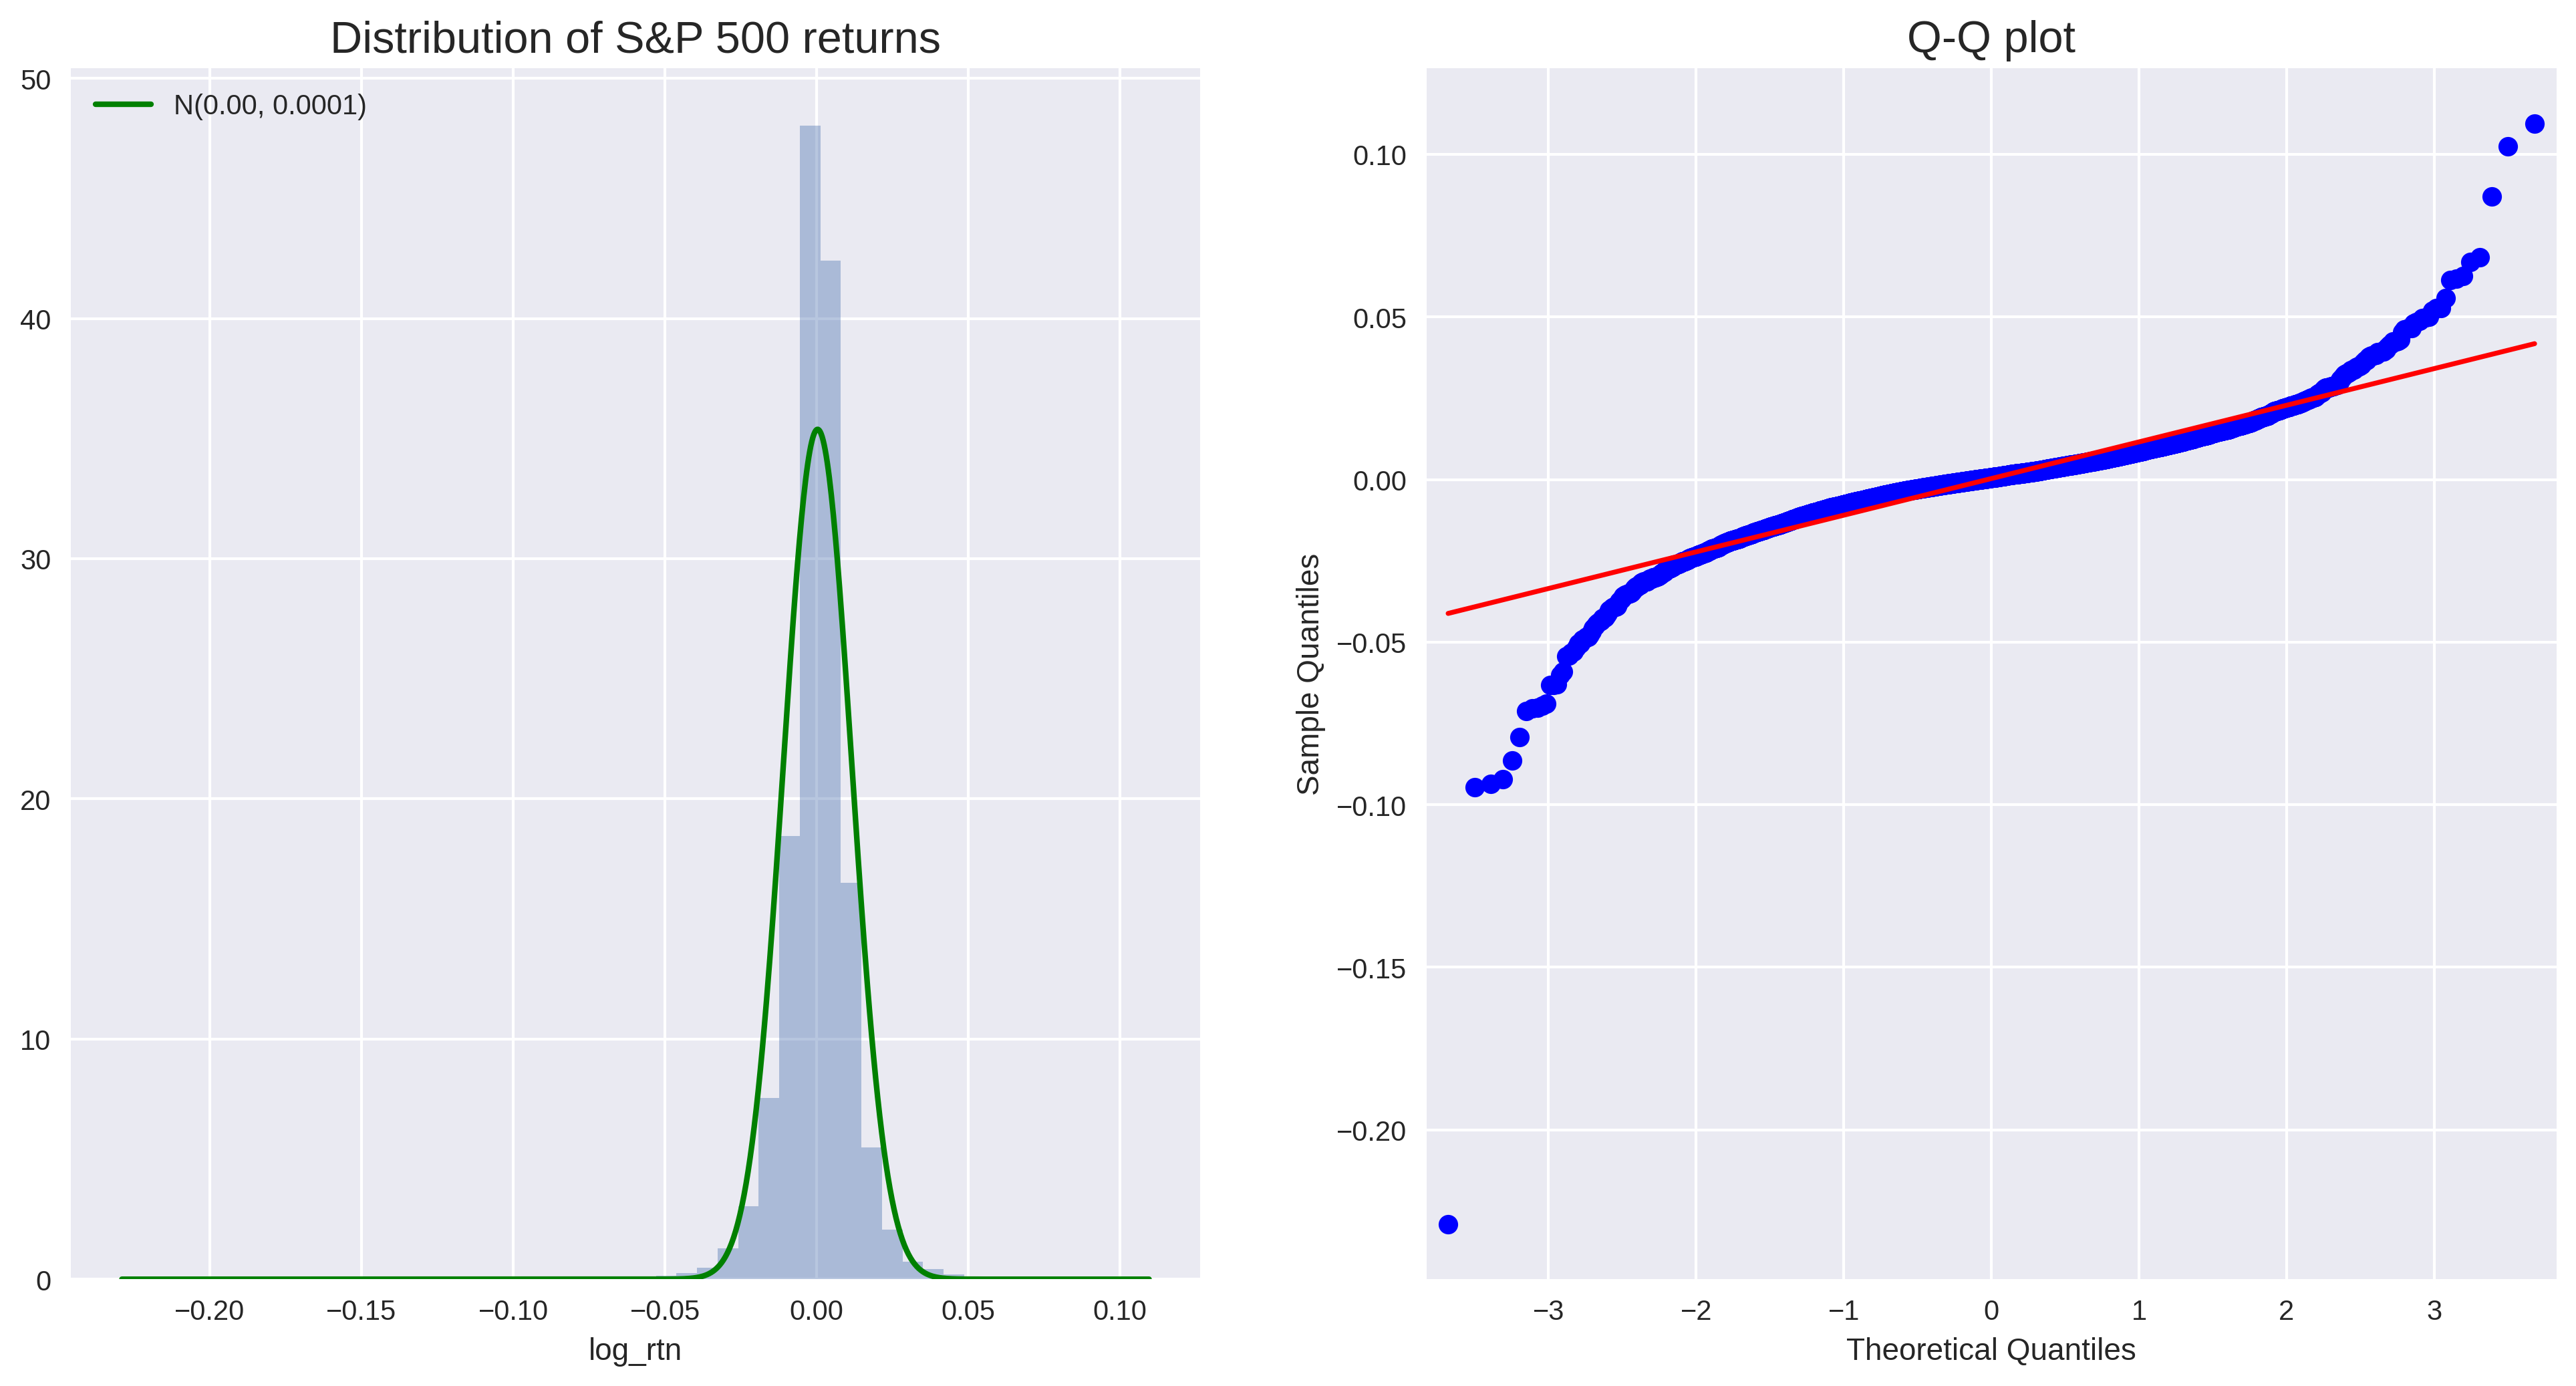

In [4]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
#histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of S&P 500 returns', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2,
          label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left')

#Q-Q plot 
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize=16)

In [5]:
jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}')
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}') 
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------- Descriptive Statistics ----------
Range of dates: 1985-01-03 - 2018-12-28
Number of observations: 8568
Mean: 0.0003
Median: 0.0006
Min: -0.2290
Max: 0.1096
Standard Deviation: 0.0113
Skewness: -1.2628
Kurtosis: 28.0156
Jarque-Bera statistic: 282134.38 with p-value: 0.00


In [ ]:
# With a p value < 0.05, we reject the null hypothesis that 
# SAMPLE DATA HAS SKEWNESS AND KURTOSIS MATCHING THOSE OF A GAUSSIAN DESTRIBUTION

# Vlatility clustering

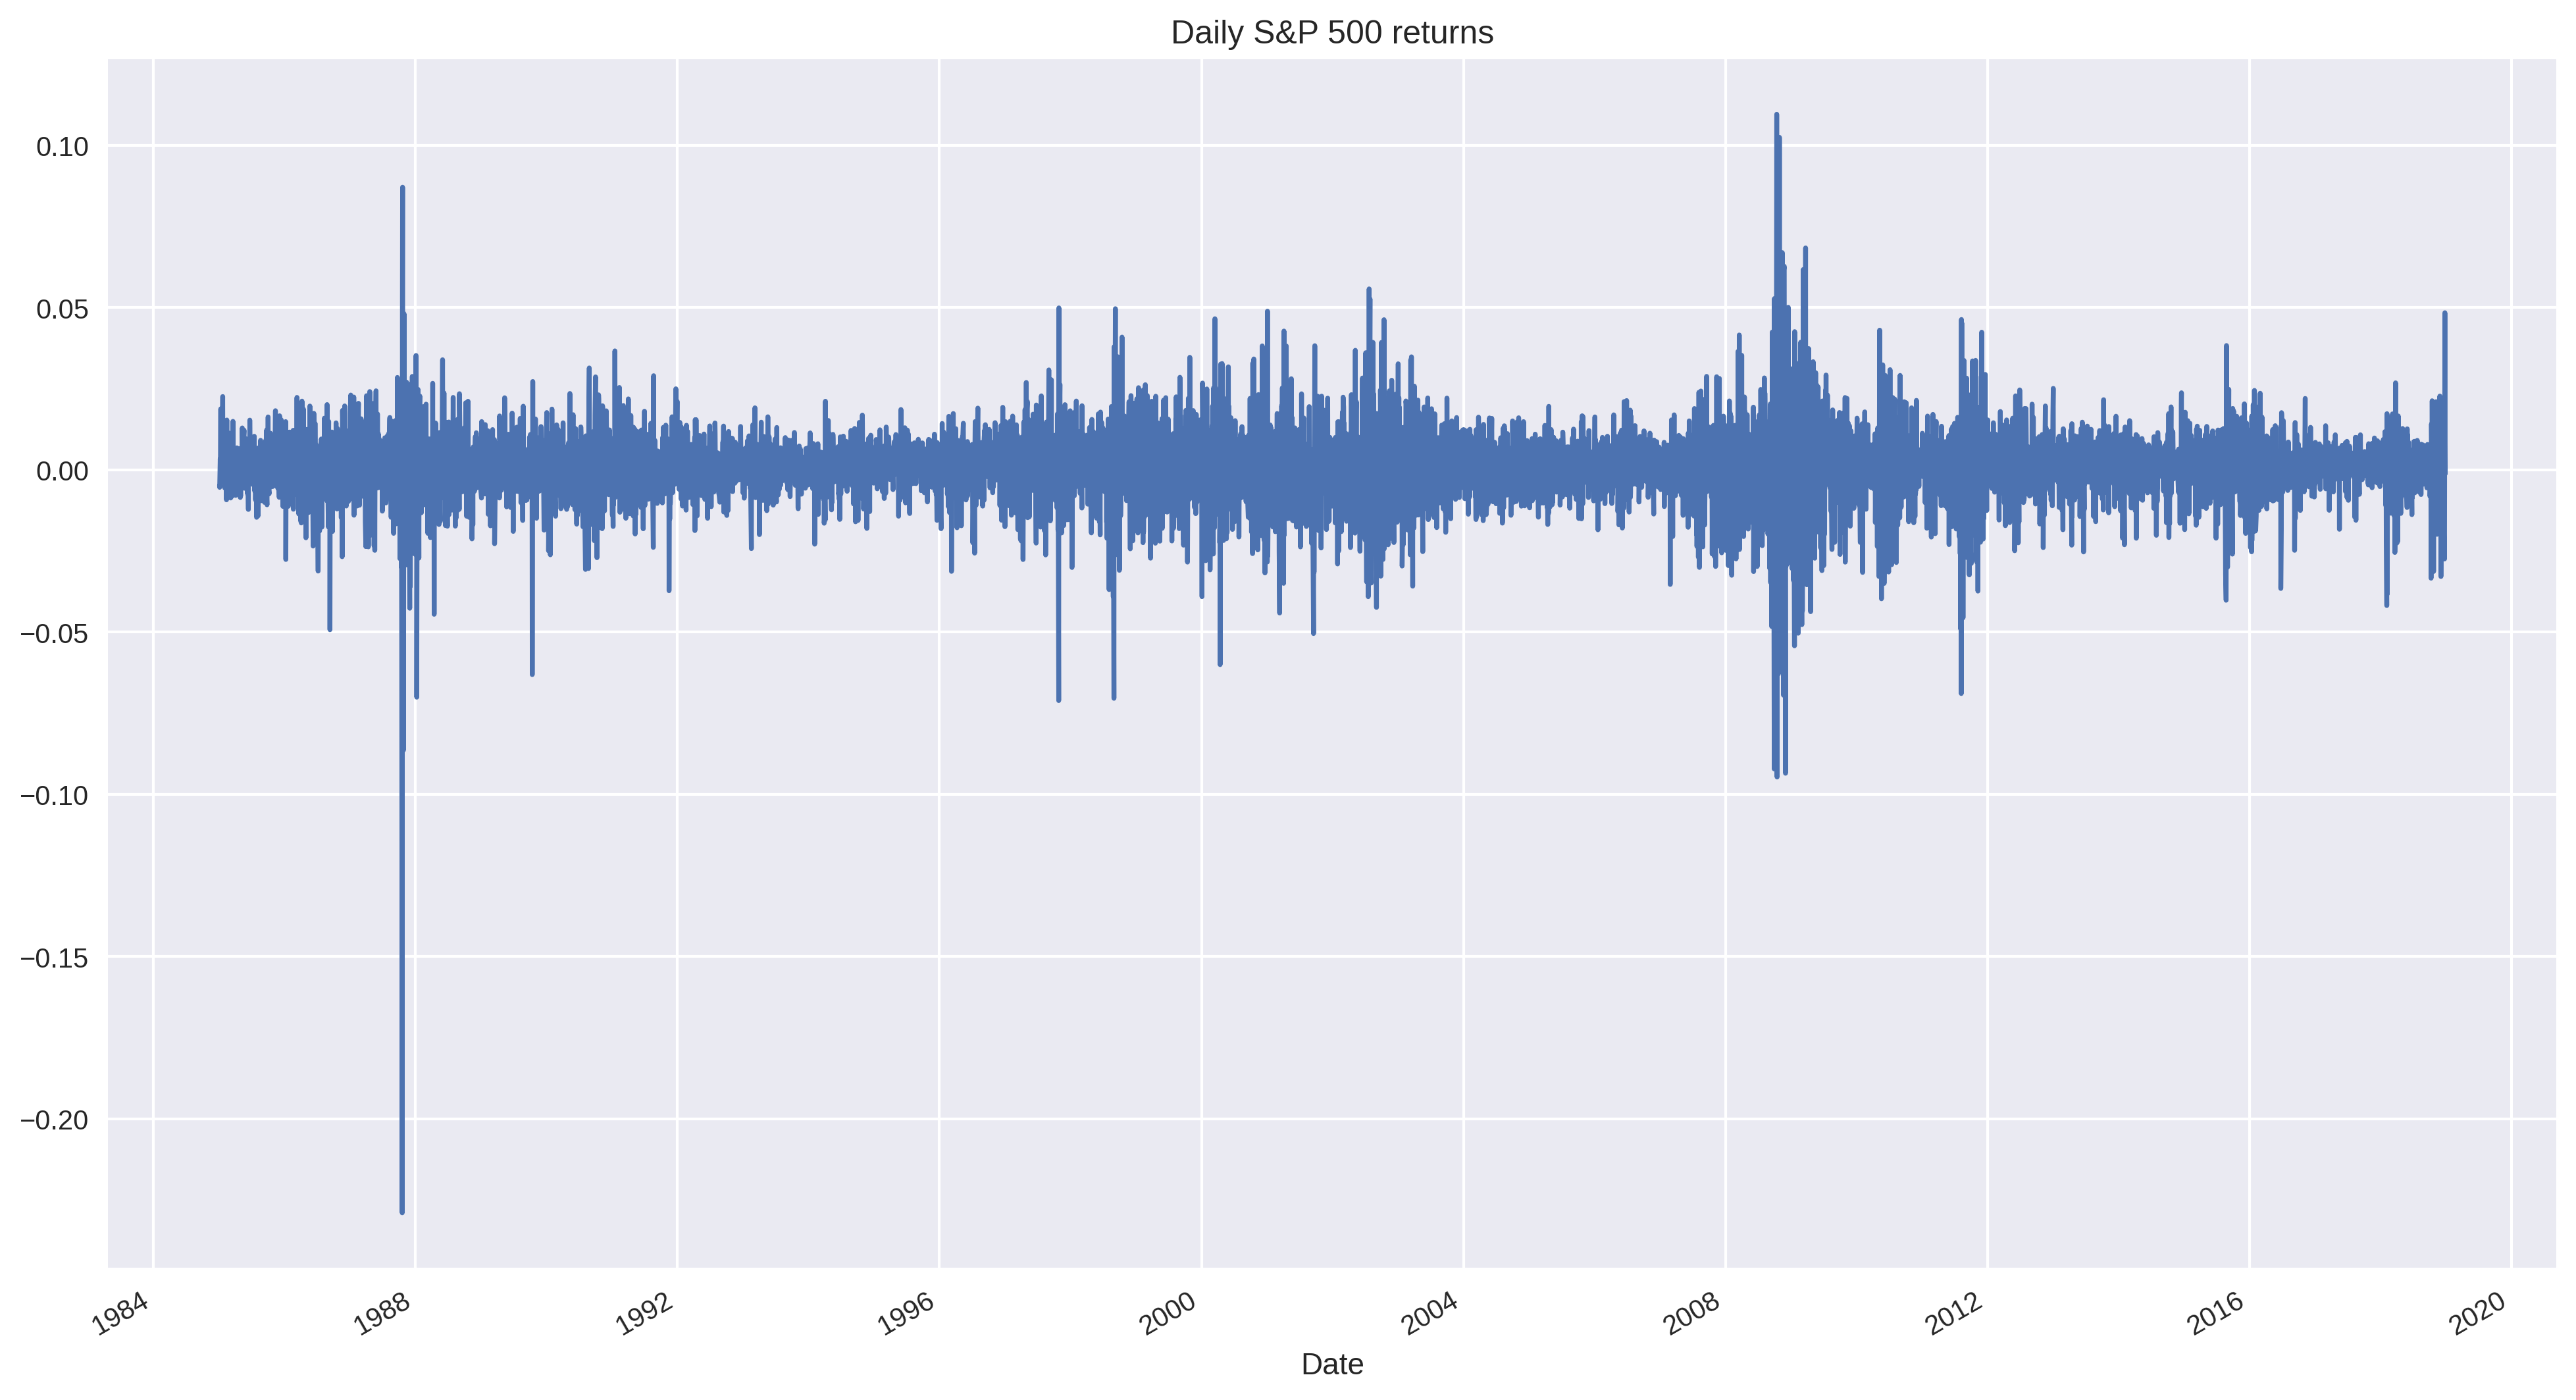

In [13]:
df.log_rtn.plot(title='Daily S&P 500 returns');
# Volatility is not constant

# Absence of autocorrelation in returns

In [7]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

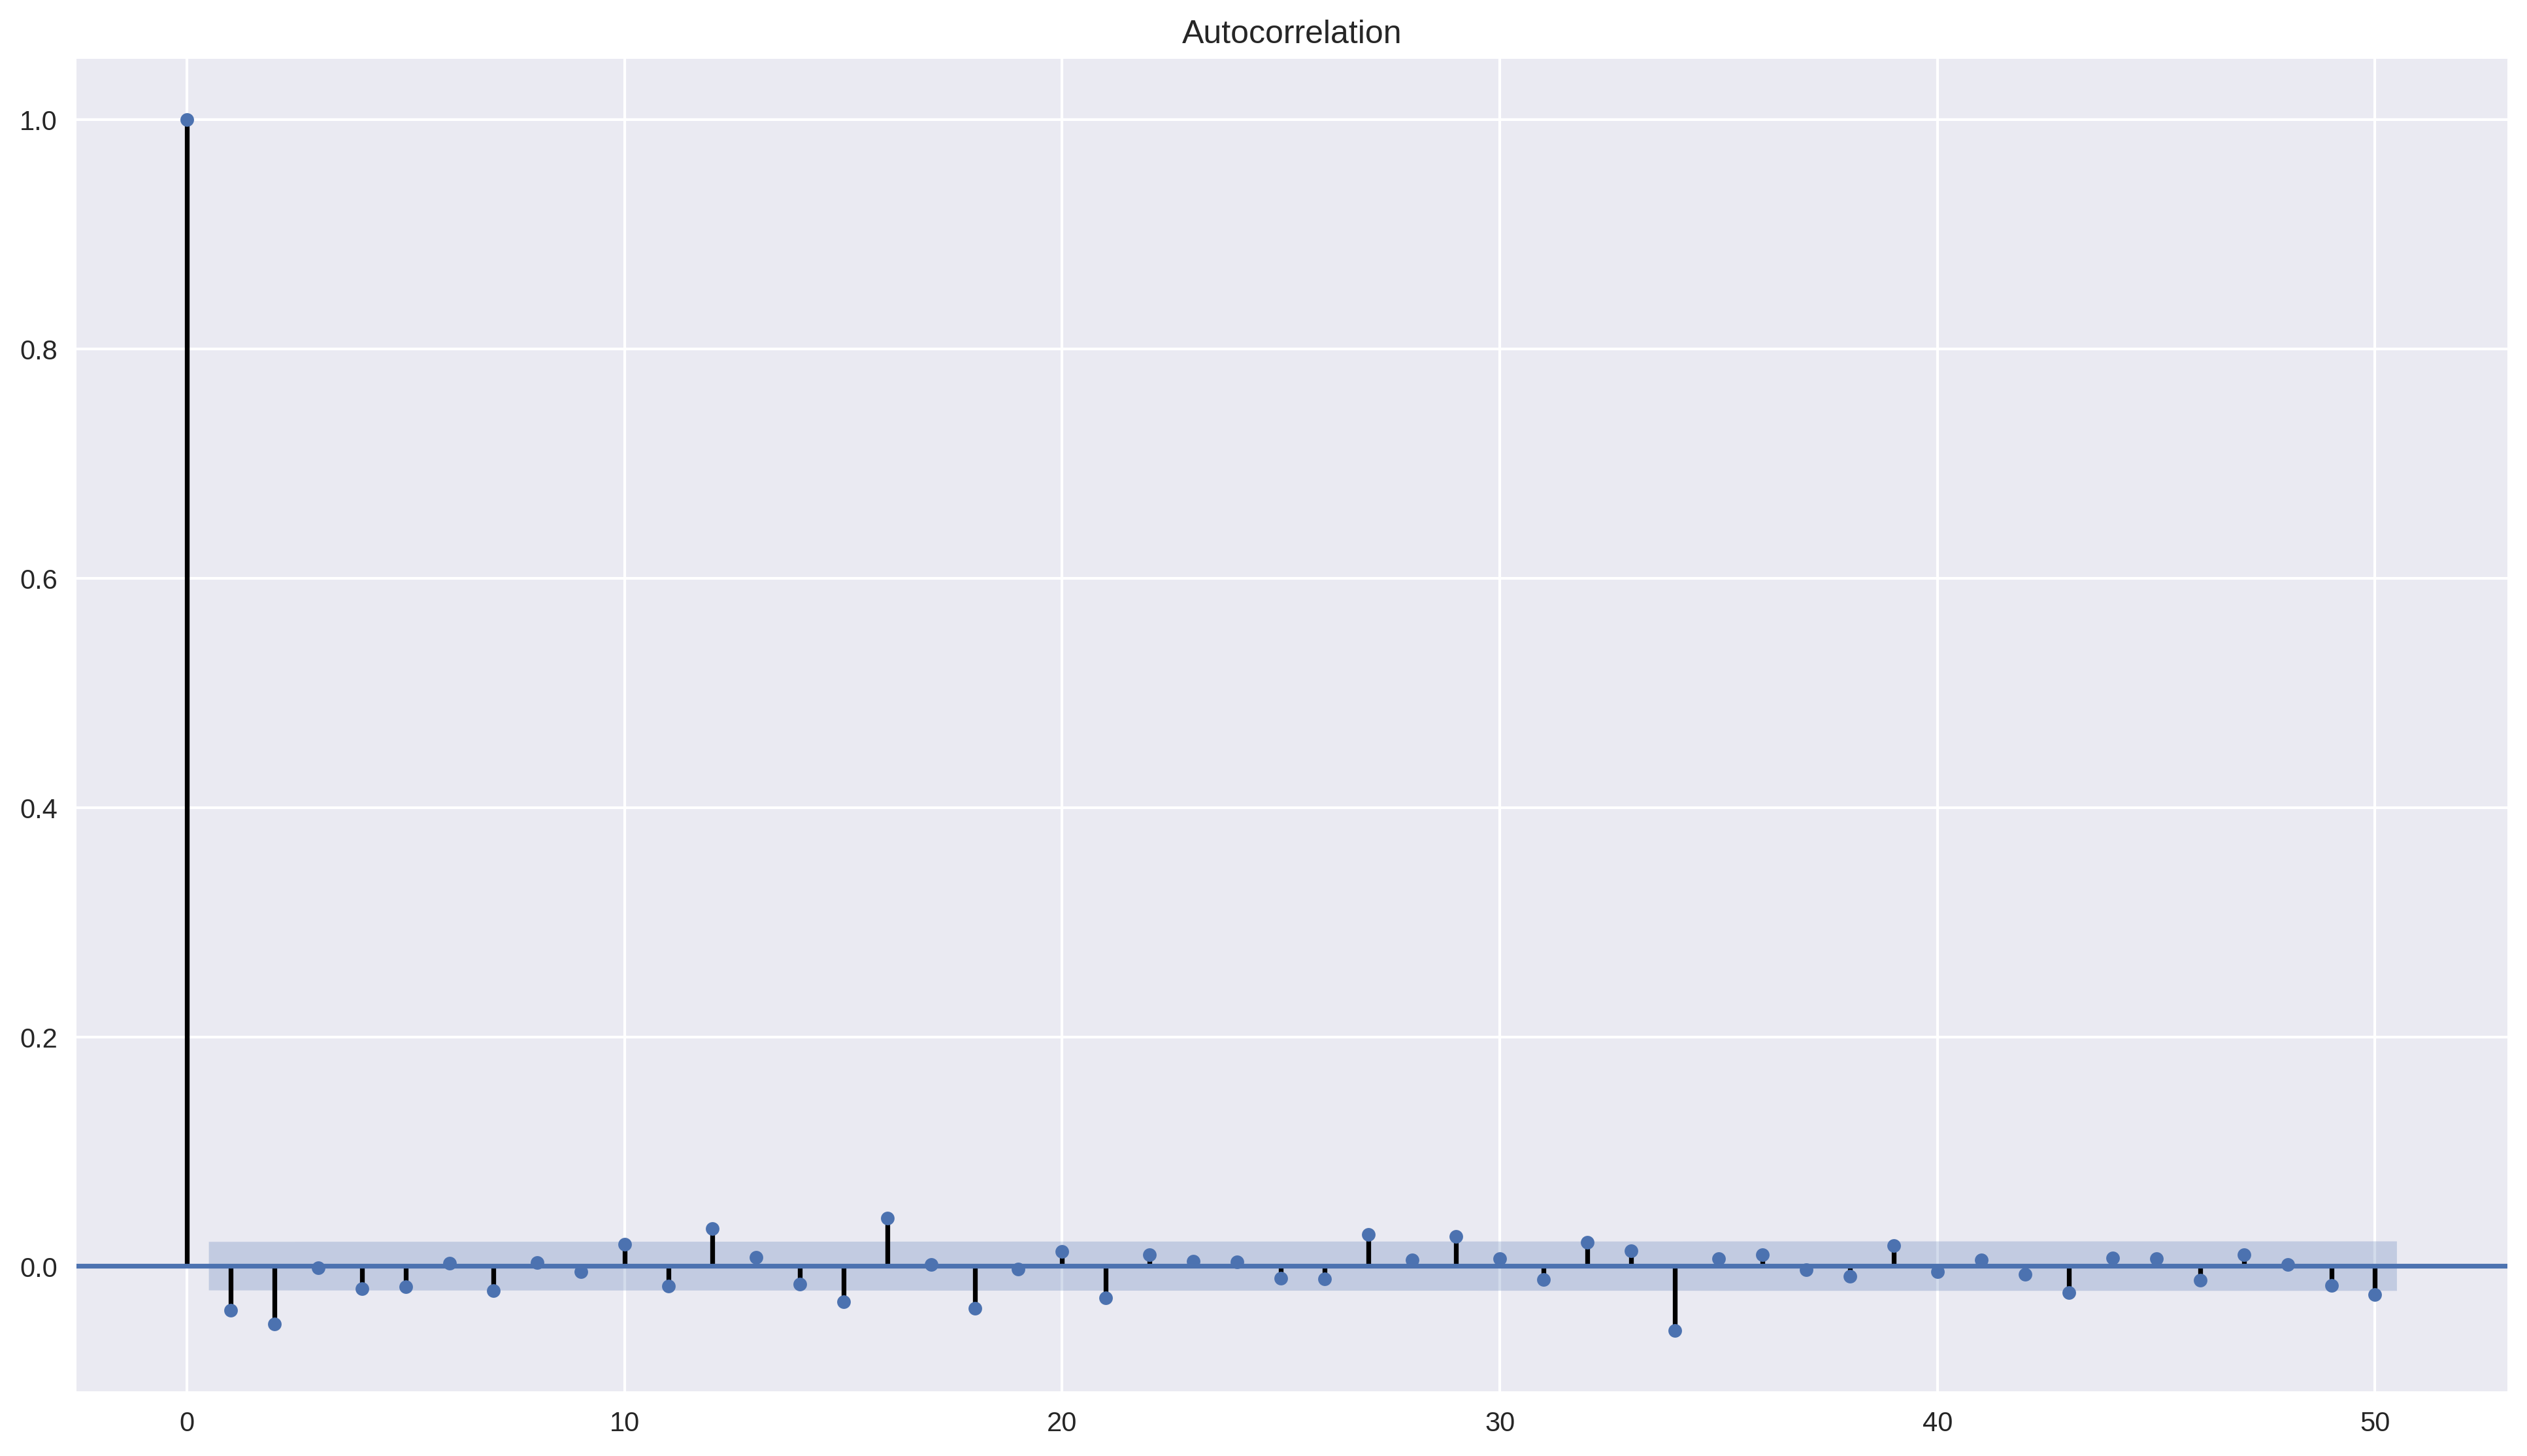

In [18]:
acf = smt.graphics.plot_acf(df.log_rtn,
                           lags=N_LAGS,
                           alpha=SIGNIFICANCE_LEVEL)


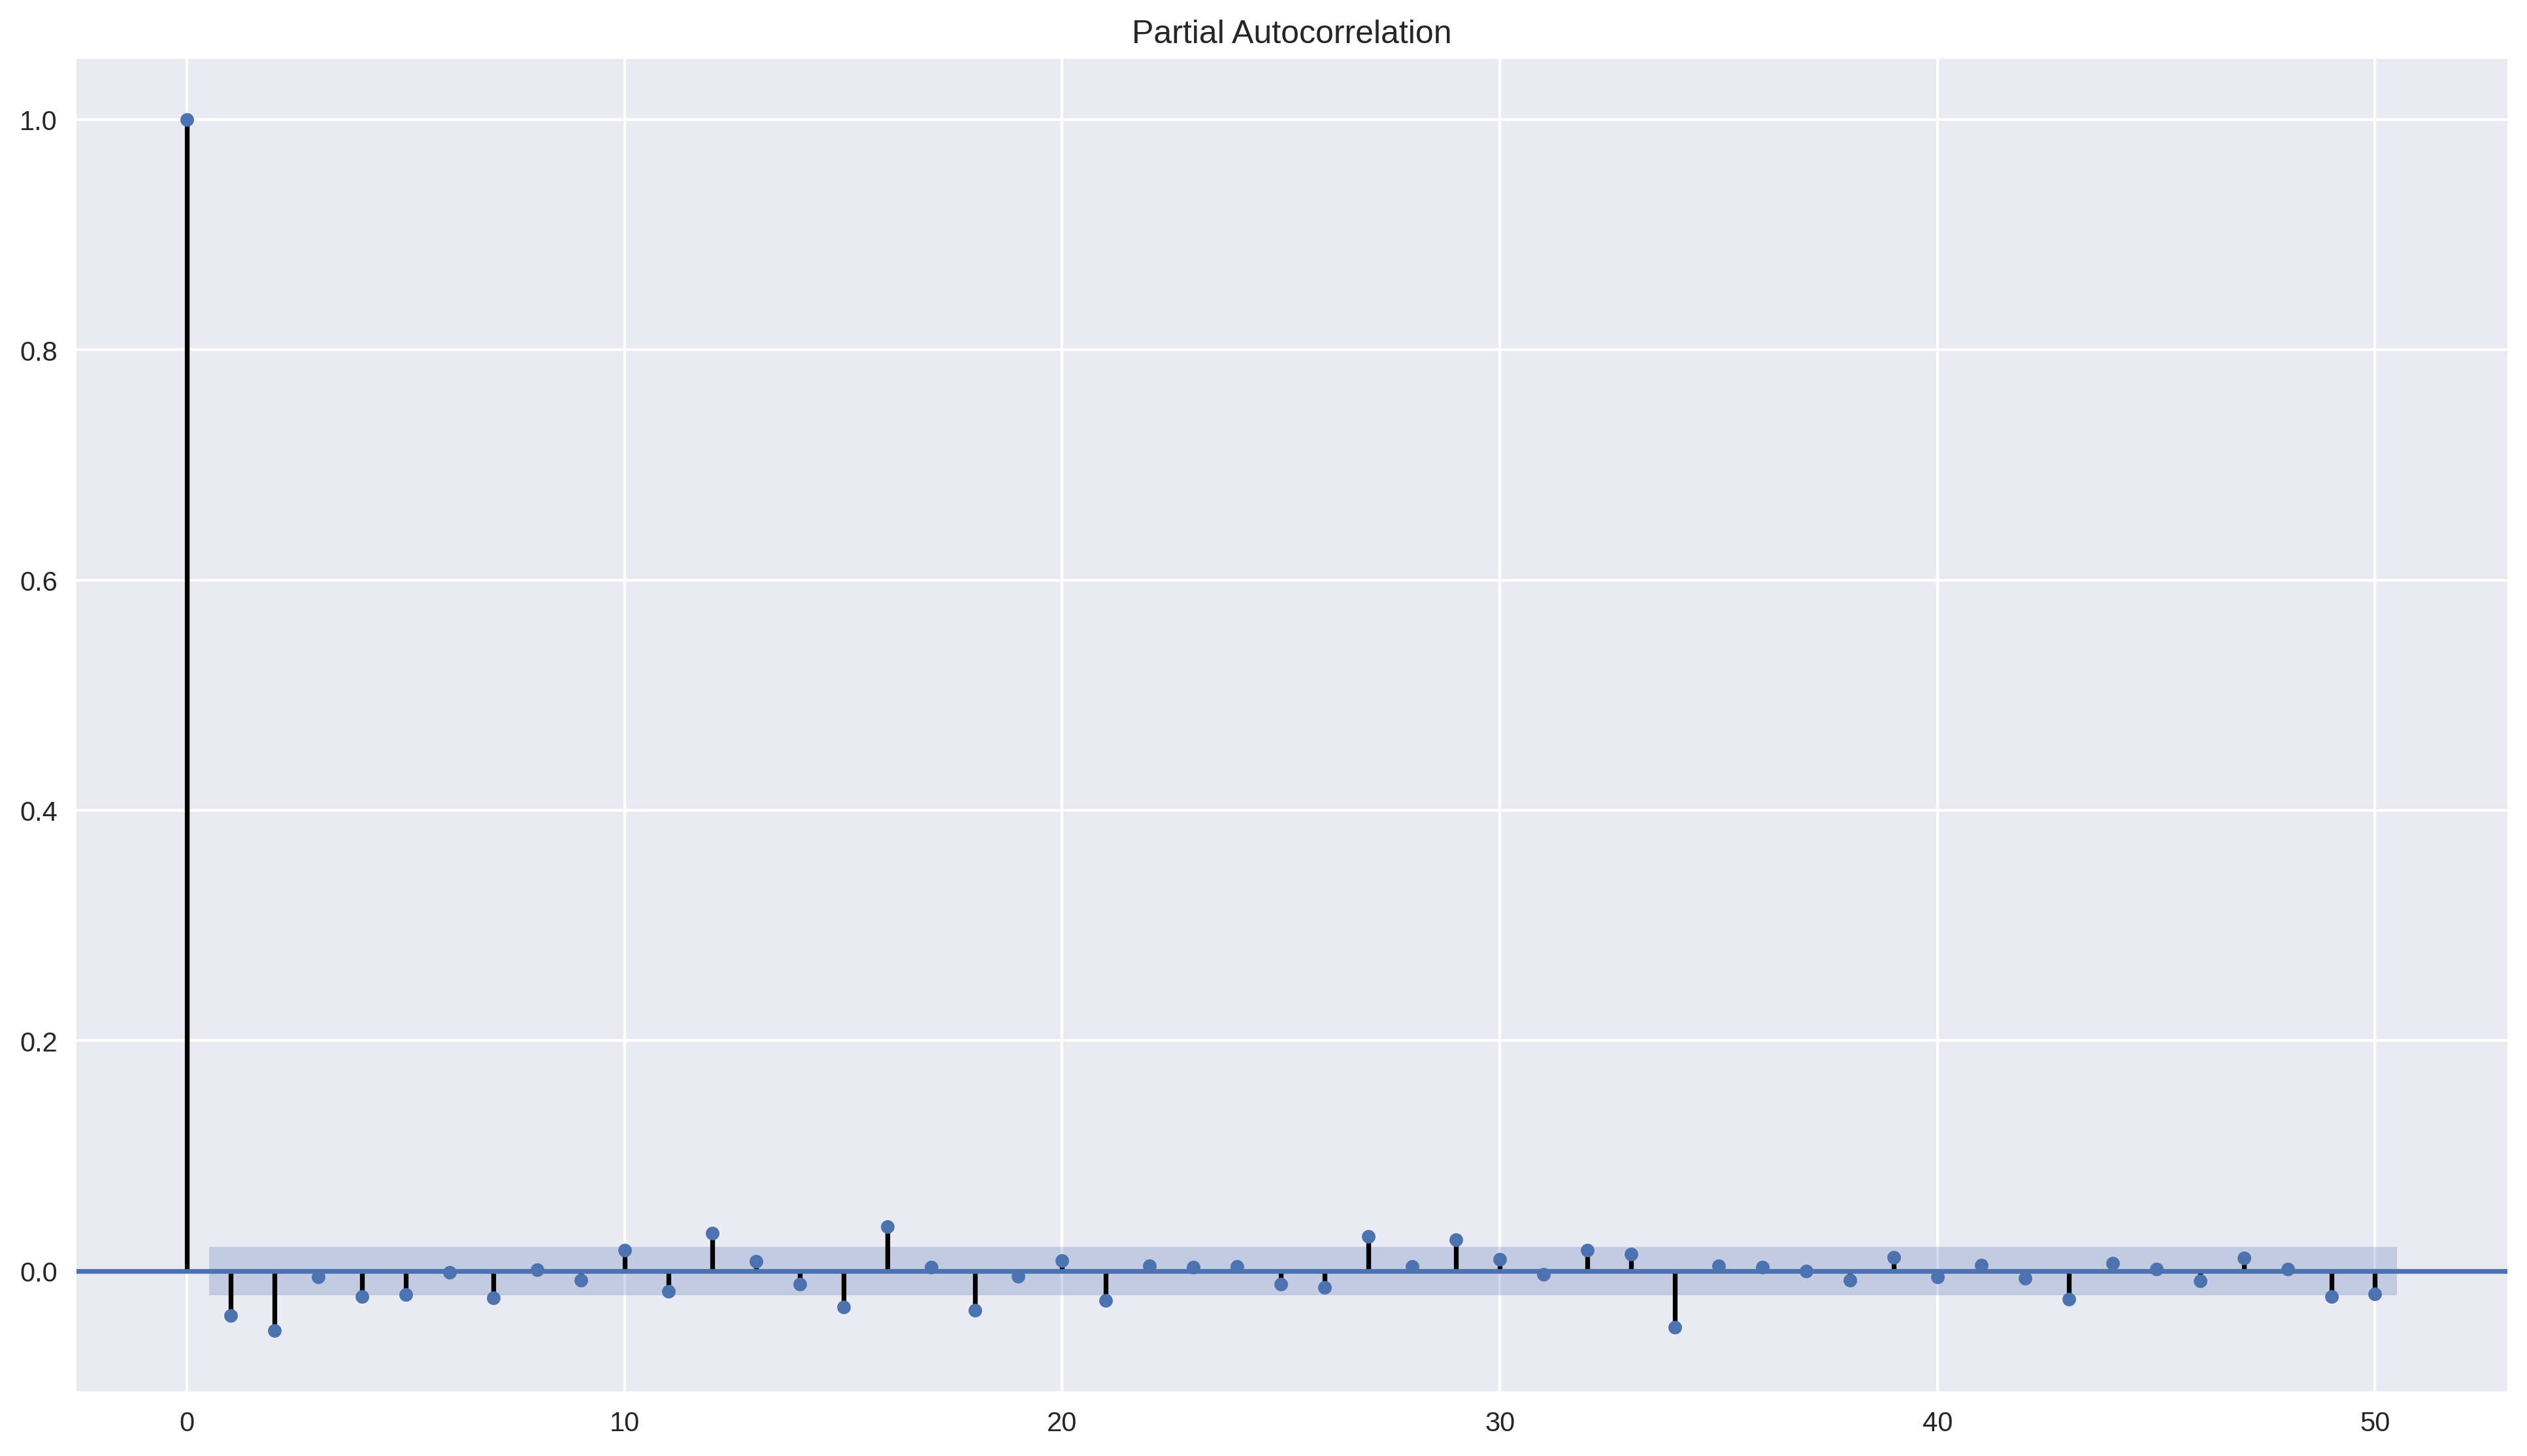

In [9]:
pacf = smt.graphics.plot_pacf(df.log_rtn,
                             lags=N_LAGS,
                             alpha=SIGNIFICANCE_LEVEL)

# Small and decreasing autocorrelation in squared/absolute returns

[Text(0, 0.5, 'Absolute Returns'), Text(0.5, 0, 'Lag')]

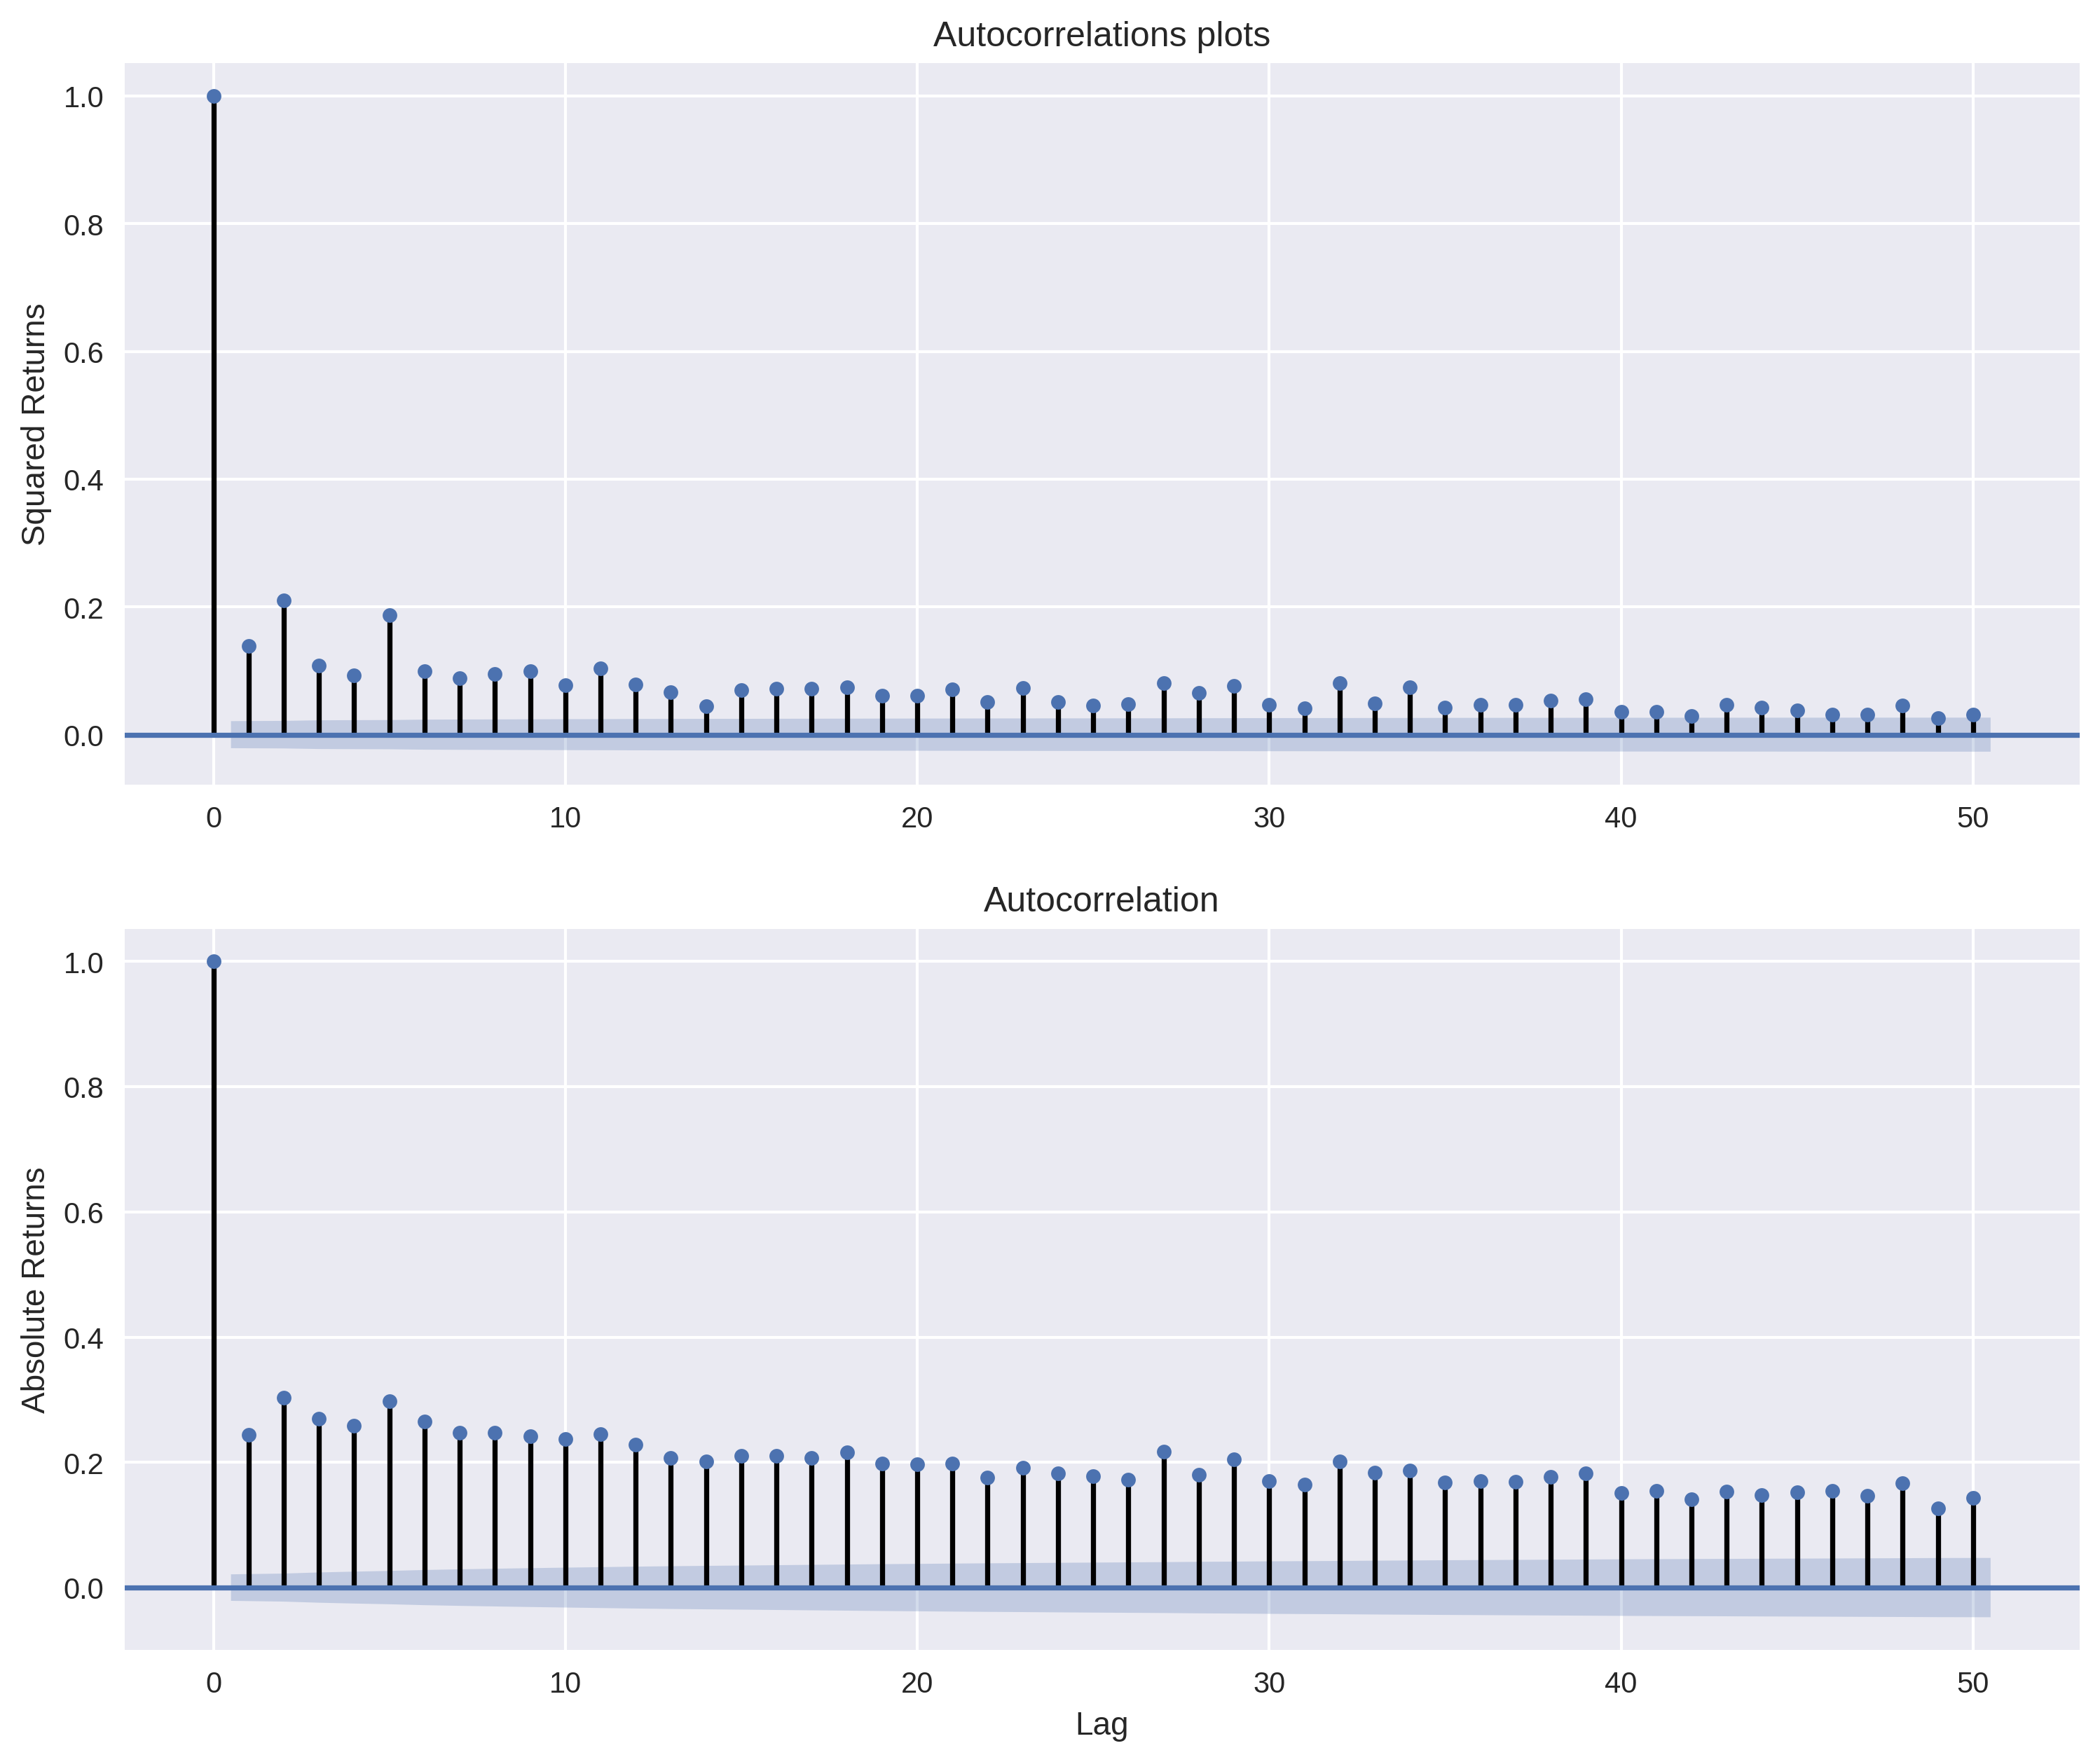

In [10]:
fig, ax = plt.subplots(2,1,figsize=(12,10))
smt.graphics.plot_acf(df.log_rtn**2, lags=N_LAGS,
                     alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelations plots',
         ylabel = 'Squared Returns')
smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS,
                     alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel='Absolute Returns',
         xlabel='Lag')

# Leverage effect

In [11]:
df['moving_std_252']=df[['log_rtn']].rolling(window=252).std()
df['moving_std_21']=df[['log_rtn']].rolling(window=21).std()

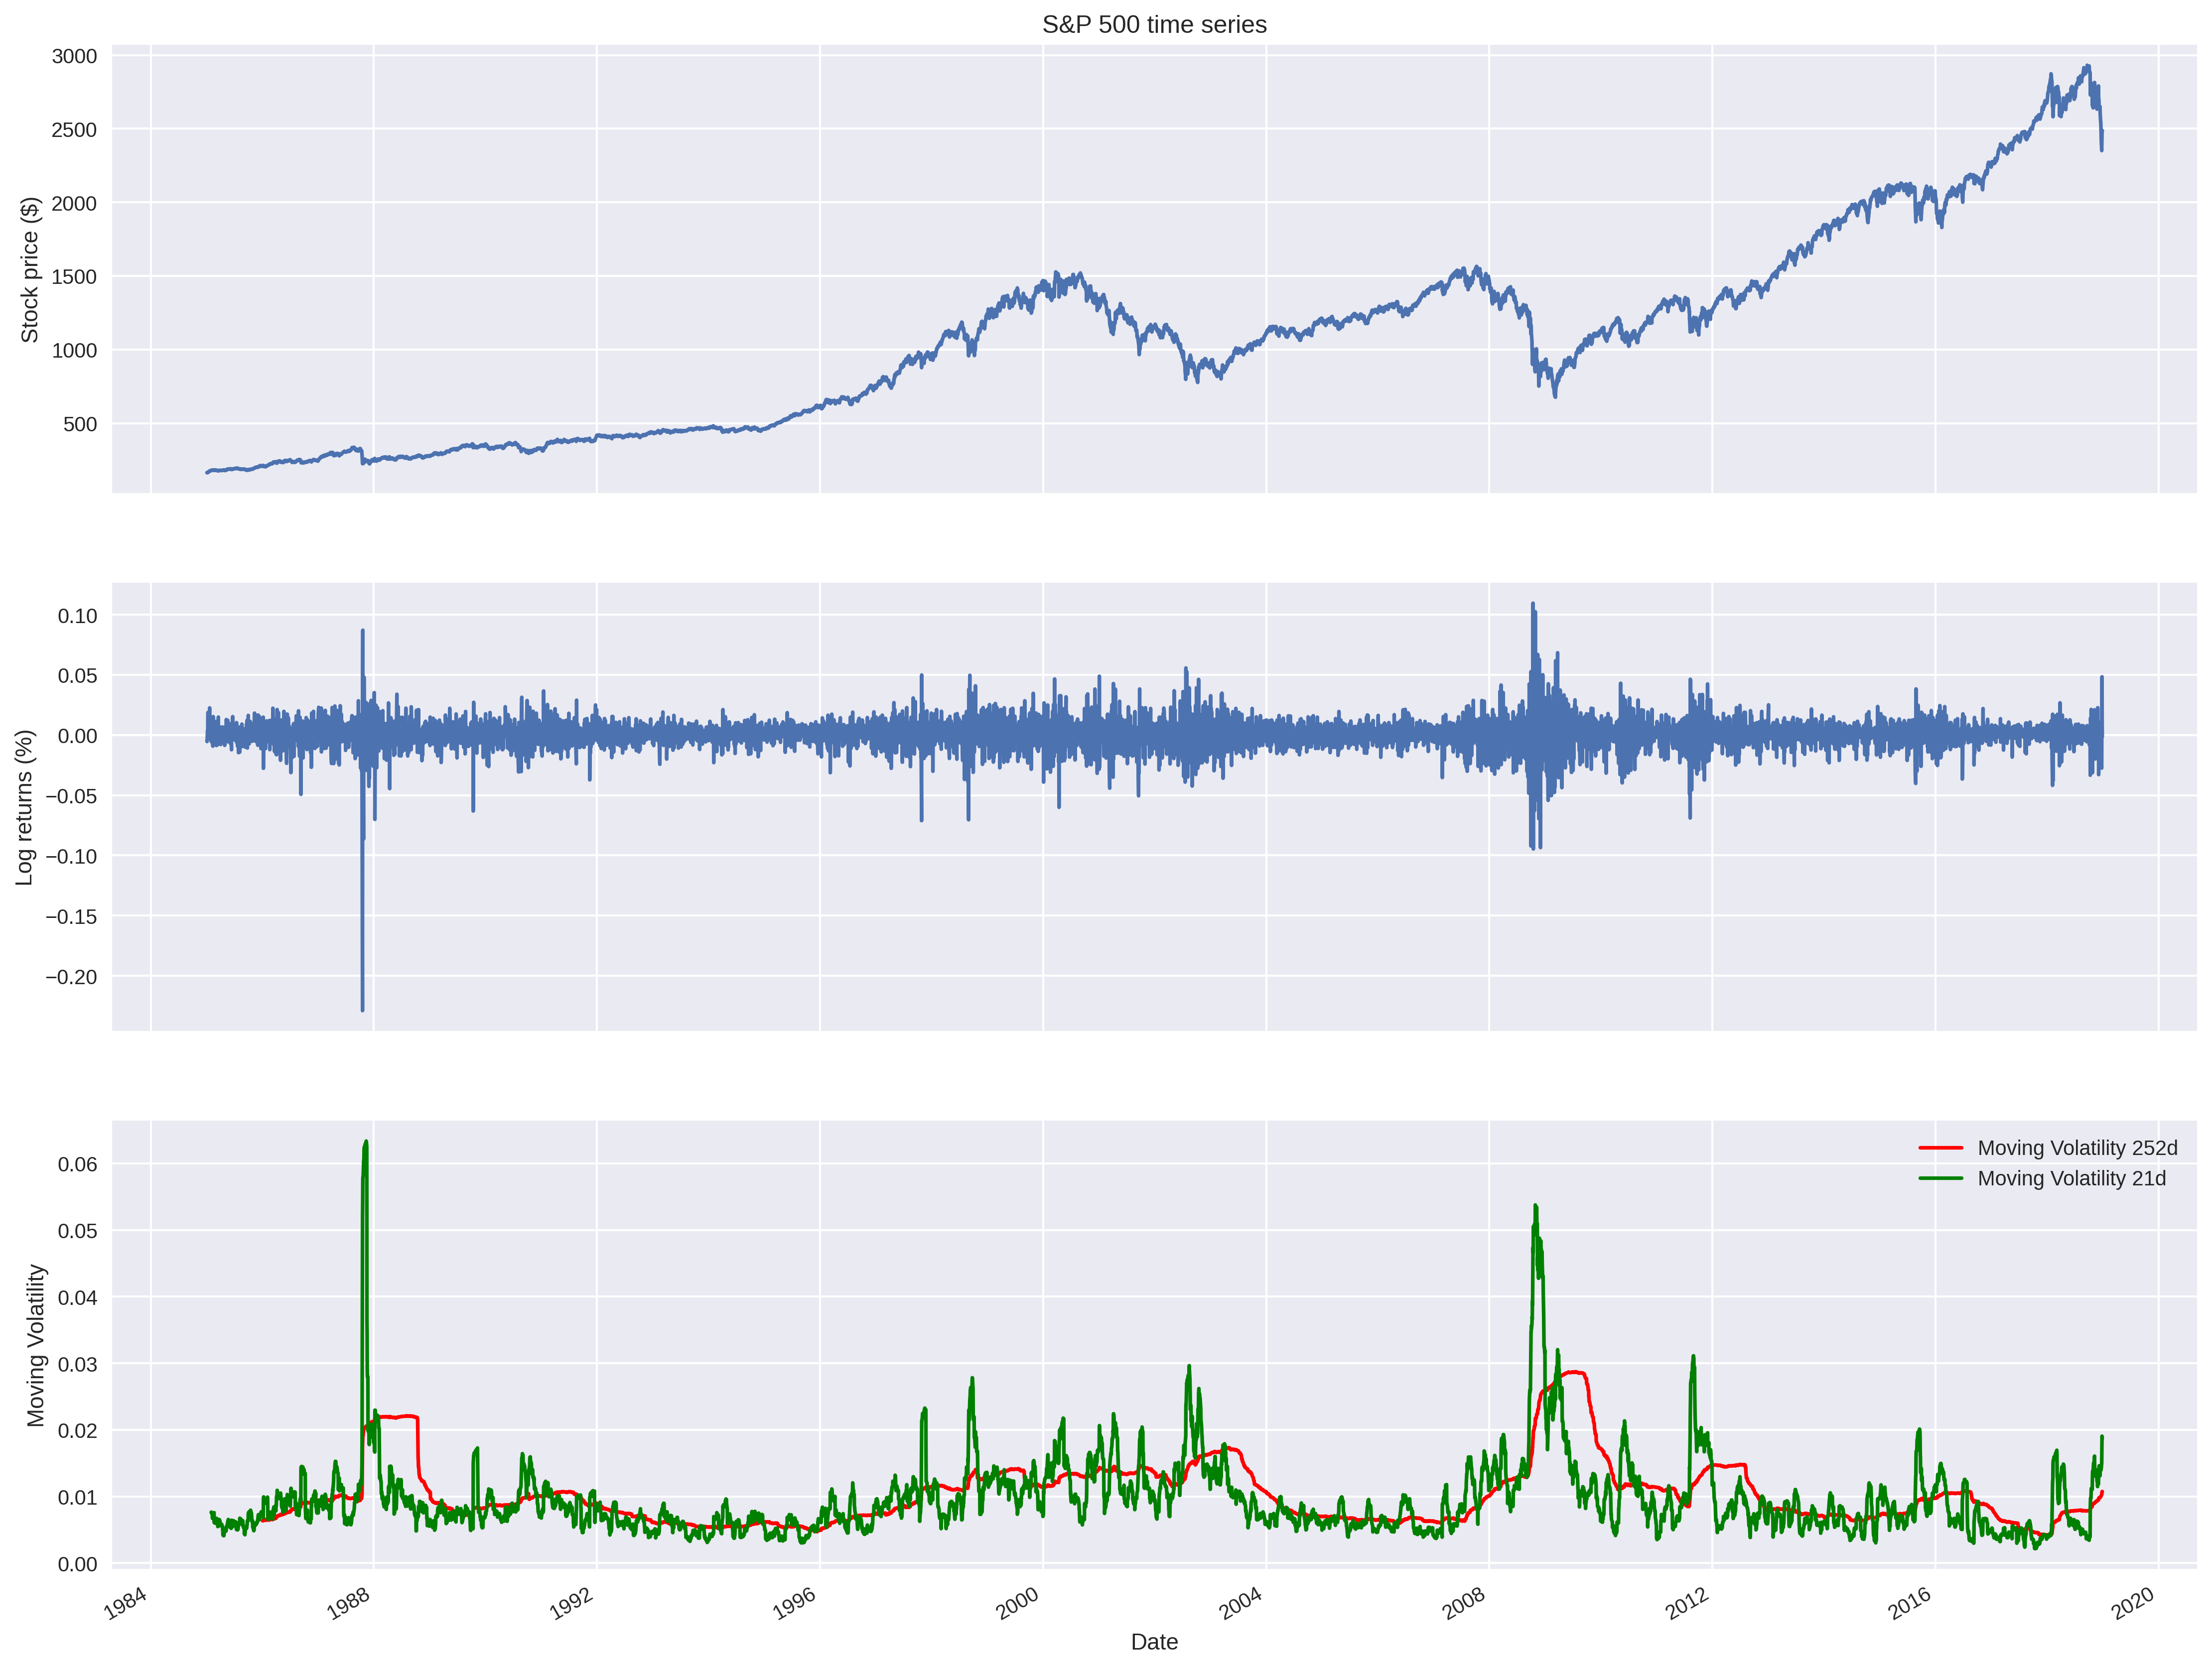

In [12]:
fig, ax = plt.subplots(3,1,figsize=(18,15),
                      sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set(title='S&P 500 time series',
         ylabel='Stock price ($)')
df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Log returns (%)')

df.moving_std_252.plot(ax=ax[2], color='red',
                      label='Moving Volatility 252d')
df.moving_std_21.plot(ax=ax[2], color='g',
                     label='Moving Volatility 21d')
ax[2].set(ylabel='Moving Volatility',
         xlabel='Date')
ax[2].legend()

# Alternative to leverage effect

In [21]:
df = yf.download(['^GSPC','^VIX'],
                  start = '1985-01-01',
                  end = '2018-12-31',
                  progress=False)
df = df[['Adj Close']]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={'^GSPC':'sp500','^VIX':'vix'})

In [23]:
df['log_rtn'] = np.log(df.sp500/df.sp500.shift(1))
df['vol_rtn'] = np.log(df.vix/df.vix.shift(1))
df.dropna(how='any',axis=0, inplace=True)

[Text(0, 0.5, 'VIX log returns'),
 Text(0.5, 0, 'S&P500 log returns'),
 Text(0.5, 1.0, 'S&P 500 vs. VIX ($\\rho$ = -0.71)')]

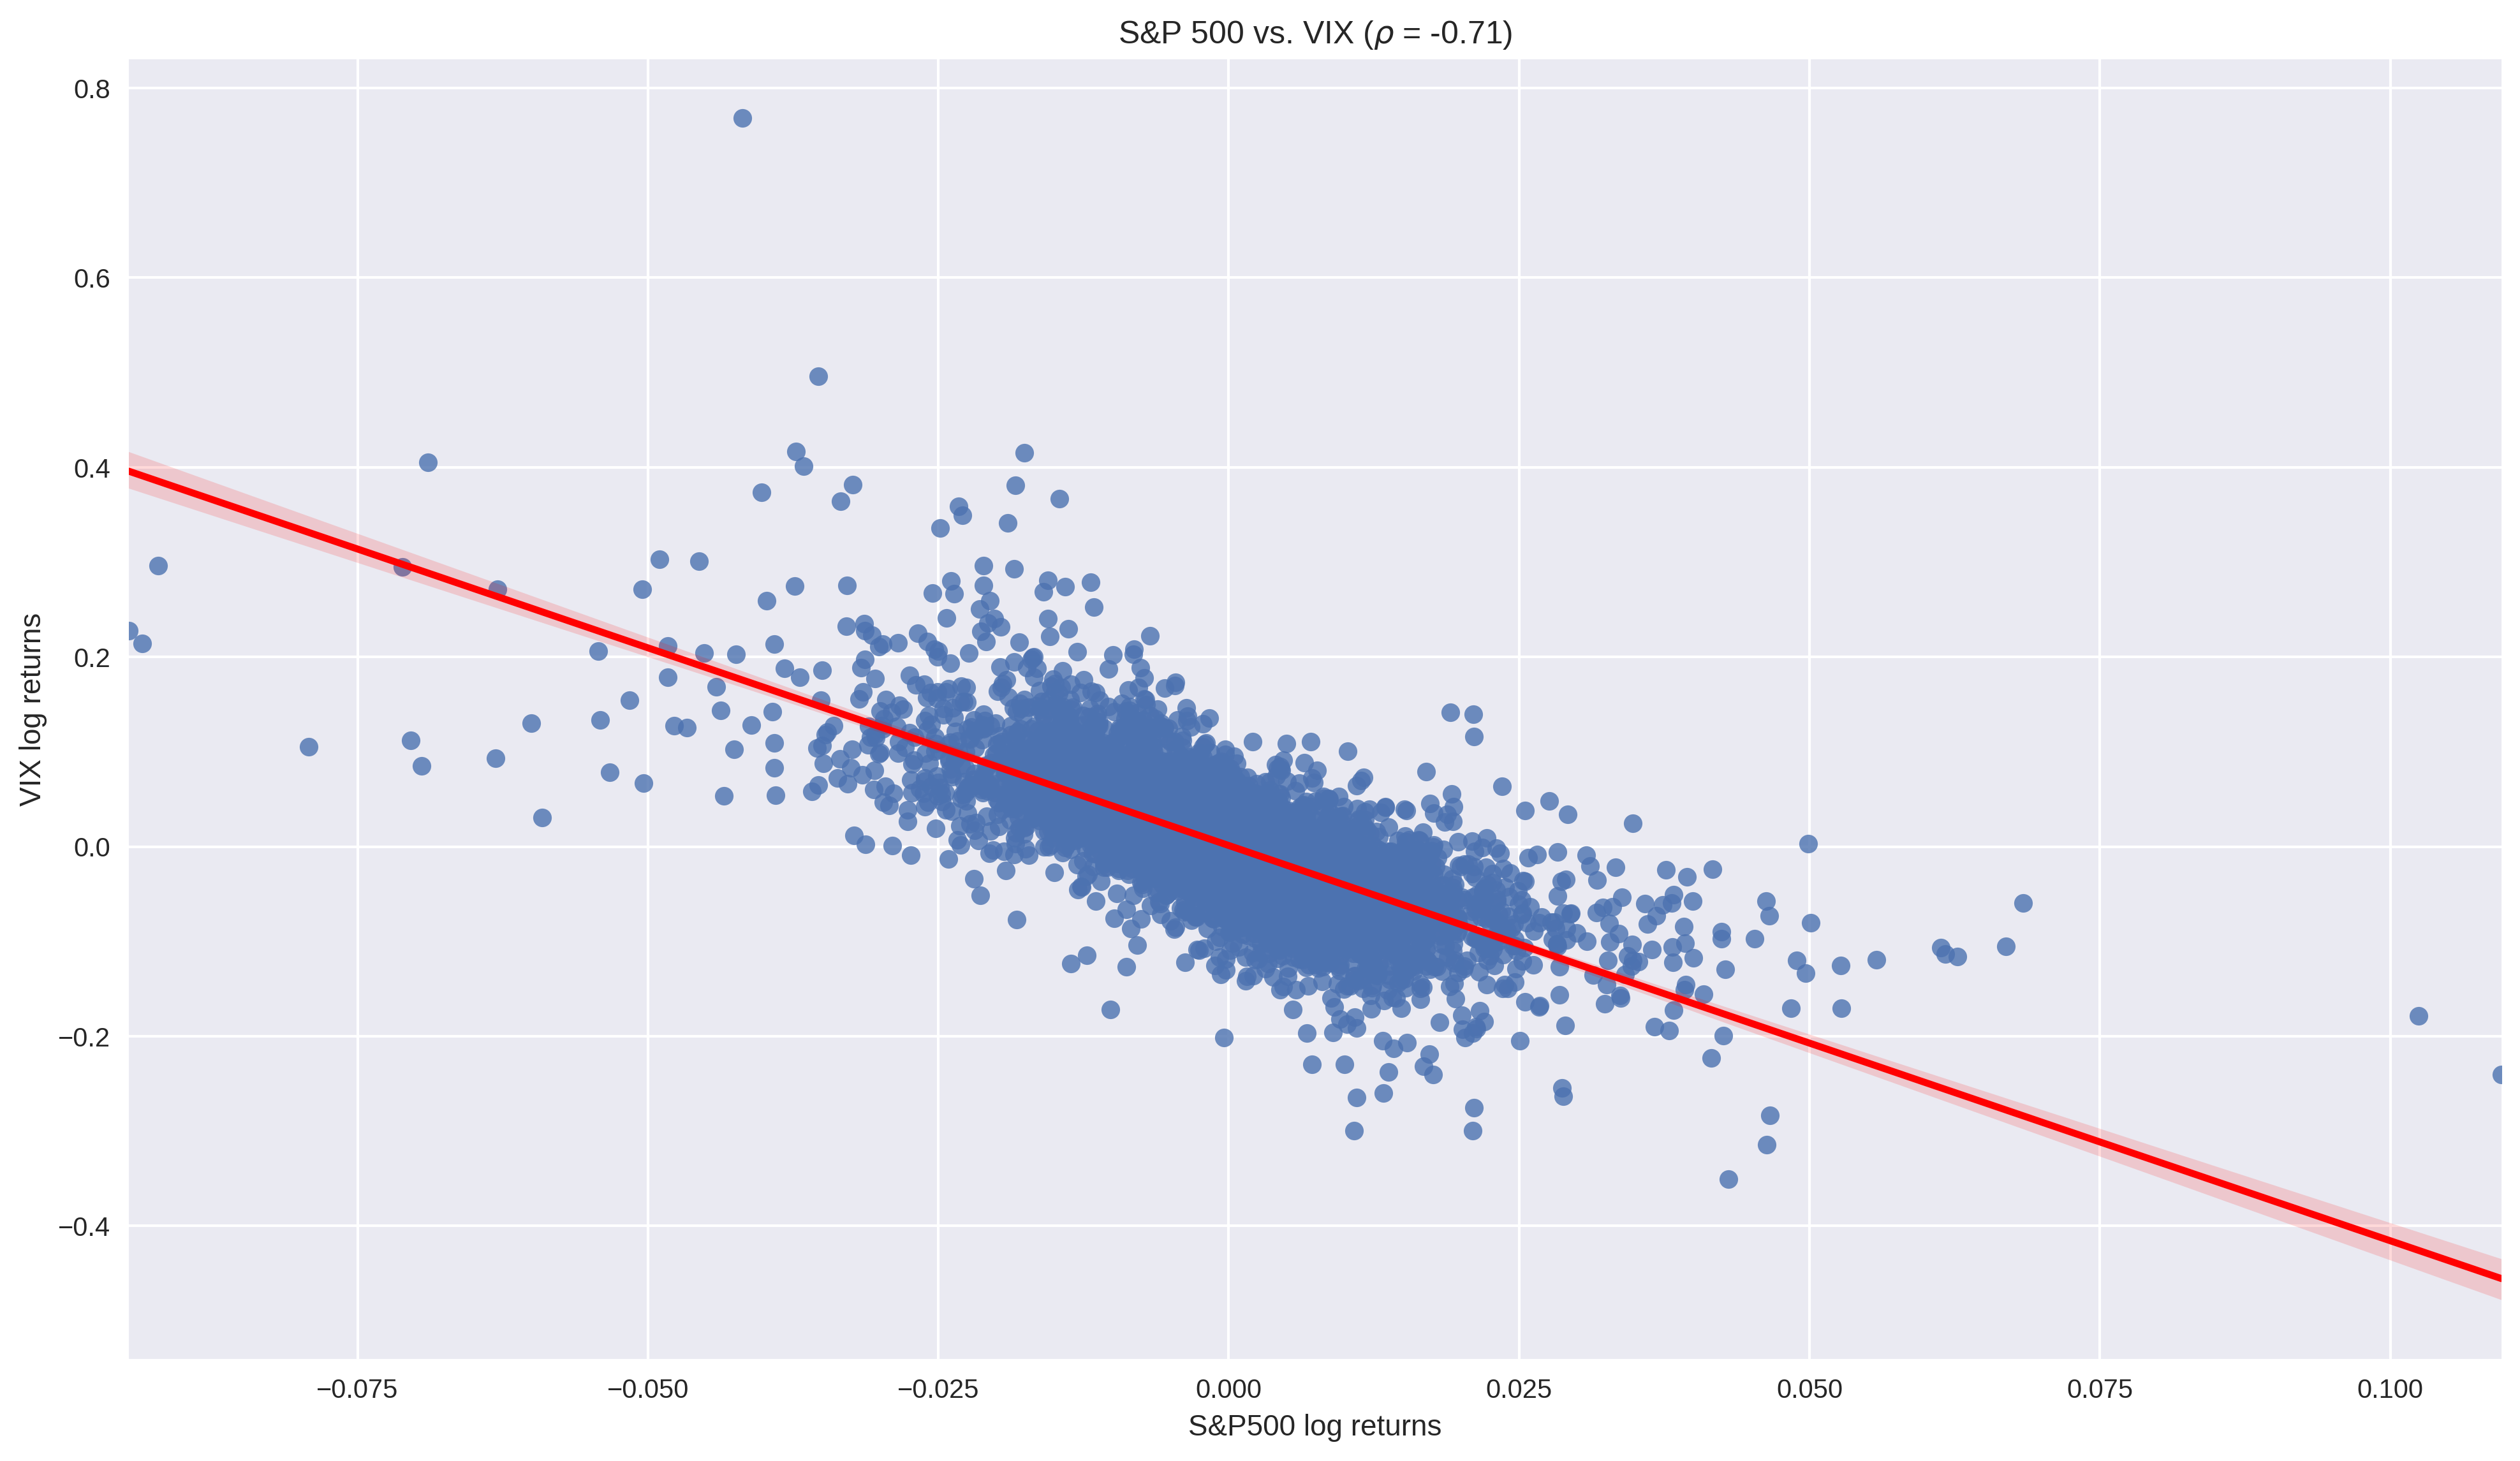

In [28]:
corr_coef = df.log_rtn.corr(df.vol_rtn)
ax = sns.regplot(x='log_rtn', y = 'vol_rtn', data=df,
                line_kws={'color':'red'})
ax.set(title=f'S&P 500 vs. VIX ($\\rho$ = {corr_coef:.2f})',
      ylabel = 'VIX log returns',
      xlabel = 'S&P500 log returns')